# Different uncertainties in time-of-transit centers

In this Notebook we address one of the referee comments of the ``juliet`` paper that is, in fact, very interesting in terms of understanding how uncertainties in periods and time-of-transit center works. 

The question of the referee was related to Figure 3 of the paper, in which we show how one of the samplers used by ``juliet``, MultiNest, is able to retrieve the multi-modal posterior distribution of the time-of transit center, $t_0$, when we allow for this latter parameter to have a very wide prior, so it spans several possible solutions. The referee pointed out that yes, MultiNest correctly samples all the time of transit centers $t_0(n) = t'_0 + nP$ (where $t'_0$ is an arbitrary time, $P$ is the period of the orbit and $n$ an integer), but the distributions for every solution $t_0(n)$ were not the same as one would a-priori expect. In this Notebook, we show why we, in fact, should *not* expect this to be the case in general, and how ``juliet``/MultiNest correctly gives the "right answer" back to us: not every $t_0(n)$ should have the same distribution. 

Let us start by reproducing that figure. First we import ``juliet``, set the same priors as the ones used in the paper, load the data and re-plot Figure 3. We will plot the original time series on top of this plot for ilustration purposes:

In [3]:
import juliet
import numpy as np
import matplotlib.pyplot as plt

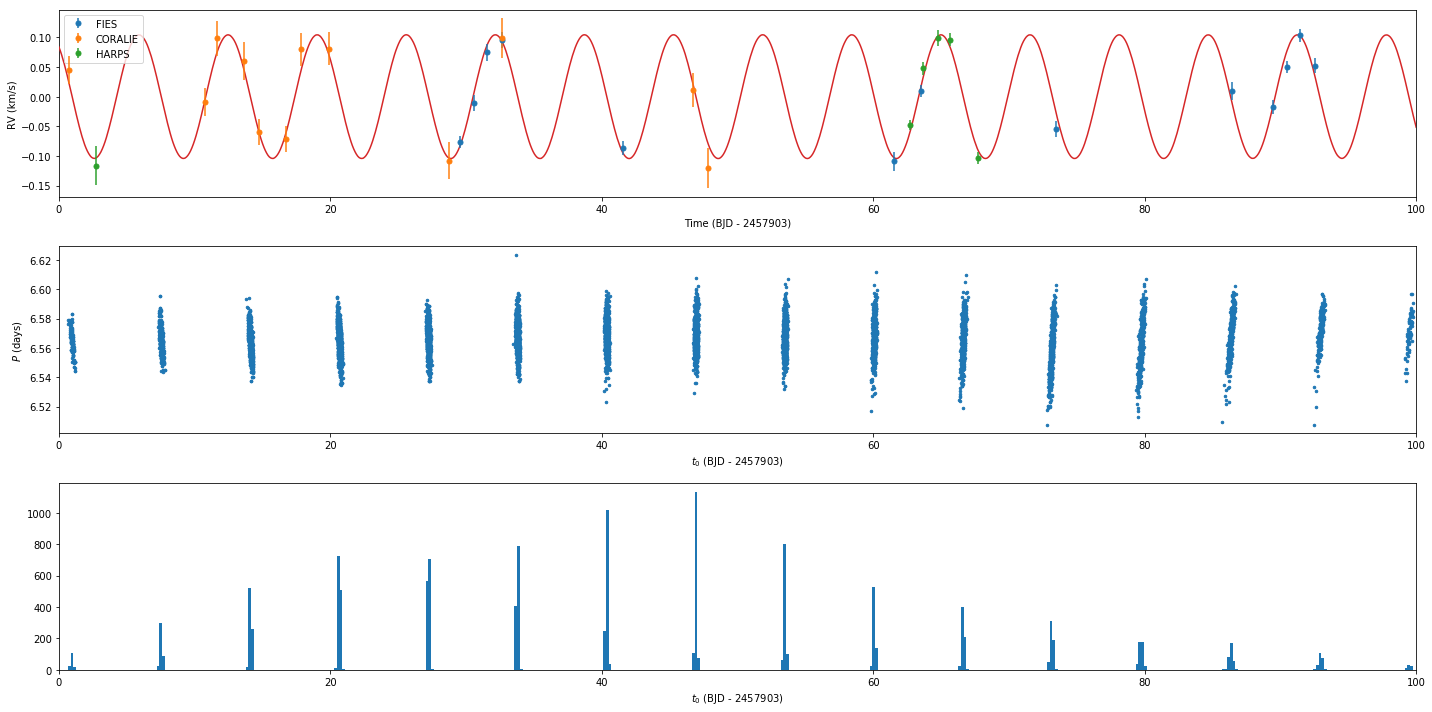

In [5]:
# Set priors (same as in Table 5 of the paper):
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','K_p1','mu_CORALIE', 'sigma_w_CORALIE', \
          'mu_HARPS','sigma_w_HARPS', 'mu_FIES', 'sigma_w_FIES', \
          'ecc_p1', 'omega_p1']

# Distributions:
dists = ['loguniform','uniform', 'uniform', 'normal','loguniform',\
         'normal','loguniform','normal','loguniform',\
         'fixed', 'fixed']

# Hyperparameters (note RVs are in km/s --- priors on Table are in m/s):
hyperps = [[0.1,100.], [2457803,2457905], [0.,1.],[1.220,0.05],[1e-4,0.1],\
           [1.240,0.05], [1e-4,0.1],[1.215,0.05],[1e-4,0.1],\
           0.0, 90.]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

# Load dataset:
dataset = juliet.load(priors = priors, rvfilename = 'K2-140_rvs.dat', out_folder = 'agnostic_fit')
# Run juliet:
results = dataset.fit()

# First, plot time series (+ best model):

fig = plt.figure(figsize=(20,10))
plt.subplot(311)
for instrument in dataset.times_rv.keys():
    mu = np.median(results.posteriors['posterior_samples']['mu_'+instrument])
    plt.errorbar(dataset.times_rv[instrument]- 2457804, dataset.data_rv[instrument]-mu,\
             dataset.errors_rv[instrument],fmt='o',label=instrument, zorder = 10)

model_times = np.linspace(2457804,2457904,1000)
model = results.rv.evaluate(instrument, t = model_times) - mu
plt.plot(model_times - 2457804, model, zorder = 5)
plt.xlim([0,100])
plt.xlabel('Time (BJD - 2457903)')
plt.ylabel('RV (km/s)')
plt.legend()

# Now plot posterior of period and time-of-transit center(s):
plt.subplot(312)
plt.plot(results.posteriors['posterior_samples']['t0_p1'] - 2457804, \
         results.posteriors['posterior_samples']['P_p1'],'.')
plt.xlabel('$t_0$ (BJD - 2457903)')
plt.ylabel('$P$ (days)')
plt.xlim([0,100])

plt.subplot(313)
plt.hist(results.posteriors['posterior_samples']['t0_p1']- 2457804,normed=False, bins=500)
plt.xlabel('$t_0$ (BJD - 2457903)')
plt.xlim([0,100])

plt.tight_layout()
plt.show()


As can be seen, the distributions are symmetric around the middle of the observation window (around time -50 in the above plot). As one gets away from this window, the distributions between the period and the time-of-transit center get more and more correlated (i.e., assymetric), which in turn implies that the time-of-transit center gets more and more uncertain. This makes intuitive sense because as it is well known, the error on the time-of-transit center of future (and past!) observations is much more uncertain as one moves away from the observational window --- in other words, because the center of the observing window has data before and after it, that is the most precise time-of-transit center one can obtain.

So what defines the relative number of samples on each of the modes? Let's check if it's the prior range: let's double the size of the prior on t0, and run everything again:

  analysing data from agnostic_fit_largeprior/jomnest_.txt


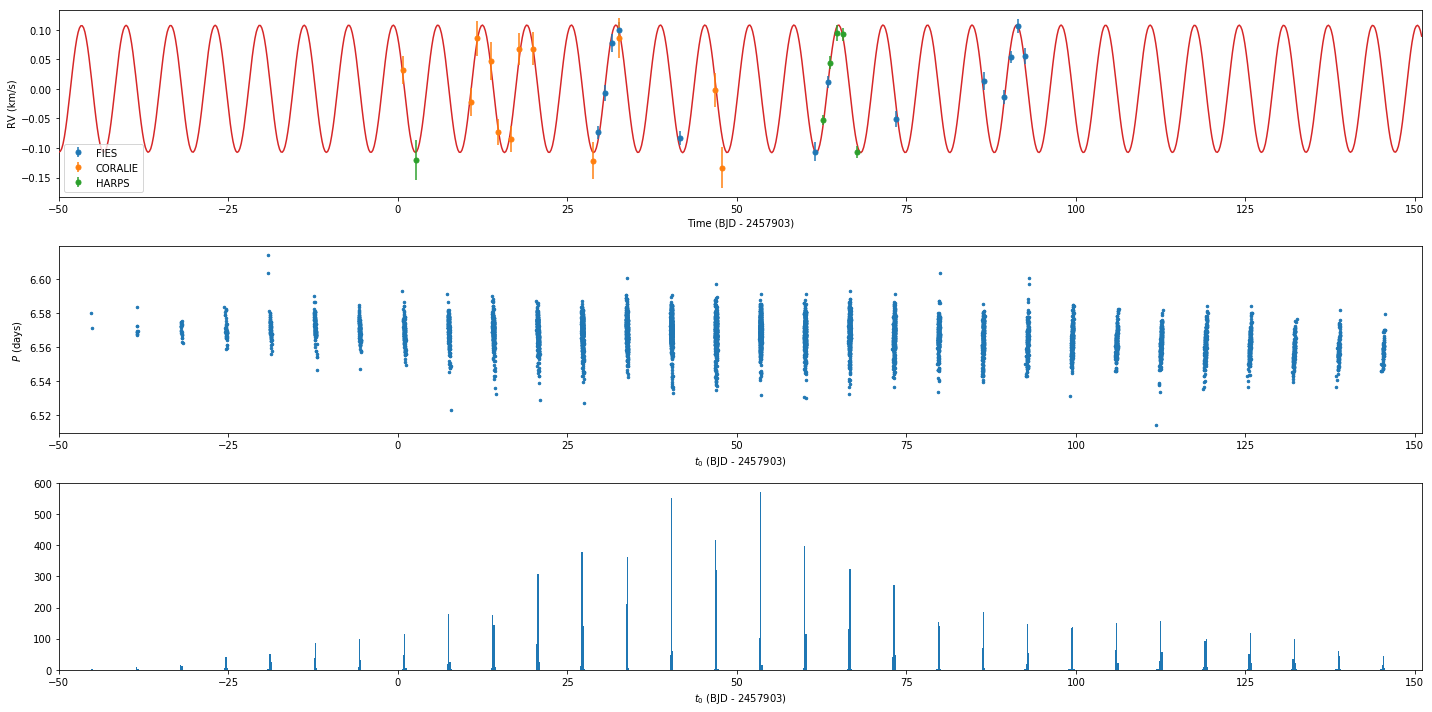

In [10]:
# Make t0 prior larger:
priors['t0_p1']['hyperparameters'] = [2457754,2457955]

# Load new dataset:
dataset2 = juliet.load(priors = priors, rvfilename = 'K2-140_rvs.dat', out_folder = 'agnostic_fit_largeprior')
# Run juliet:
results2 = dataset2.fit()

# Clear previous figure:
plt.clf()

# Plot new figure:
fig = plt.figure(figsize=(20,10))
plt.subplot(311)
for instrument in dataset2.times_rv.keys():
    mu = np.median(results2.posteriors['posterior_samples']['mu_'+instrument])
    plt.errorbar(dataset2.times_rv[instrument]- 2457804, dataset2.data_rv[instrument]-mu,\
             dataset2.errors_rv[instrument],fmt='o',label=instrument, zorder = 10)

model_times = np.linspace(2457753,2457955,1000)
model = results2.rv.evaluate(instrument, t = model_times) - mu
plt.plot(model_times - 2457804, model, zorder = 5)
plt.xlim([-50,151])
plt.xlabel('Time (BJD - 2457903)')
plt.ylabel('RV (km/s)')
plt.legend()

# Now plot posterior of period and time-of-transit center(s):
plt.subplot(312)
plt.plot(results2.posteriors['posterior_samples']['t0_p1'] - 2457804, \
         results2.posteriors['posterior_samples']['P_p1'],'.')
plt.xlabel('$t_0$ (BJD - 2457903)')
plt.ylabel('$P$ (days)')
plt.xlim([-50,151])

plt.subplot(313)
plt.hist(results2.posteriors['posterior_samples']['t0_p1'] - 2457804,normed=False, bins=1000)
plt.xlabel('$t_0$ (BJD - 2457903)')
plt.xlim([-50,151])

plt.tight_layout()
plt.show()


It is practically the same, although the effective number of samples per mode varies a little bit, specially at the edges. In any case, the symmetry with respect to the middle of the observing window is clear.